=====================================================================================================================
# **Tesla News Sentiment Stock Prediction**

This program is built on Tesla's sentiment analysis algorithm, our application extracts valuable insights from news articles related to Tesla, a leading player in the EV industry. The goal is to predict whether sentiment is negative, positive, or neutral.

=====================================================================================================================


# 1. Import Libraries

In [1]:
# Import Libraries

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re
import string

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reski\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reski\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Data Loading

In [2]:
# Data Loading

data = pd.read_csv('tweets.csv')
data

,Unnamed: 0,Date,Tweet
0,0,2023-04-10 01:00:00+00:00,"Tesla to open a new Megafactory in Shanghai, C..."
1,1,2023-04-10 00:06:05+00:00,#5things: China holds military drills around T...
2,2,2023-04-09 22:10:00+00:00,WATCH: Tesla Chief Executive Elon Musk is maki...
3,3,2023-04-09 21:41:02+00:00,Tesla’s Model S and X are starting to show the...
4,4,2023-04-09 20:00:00+00:00,"How the market’s biggest companies, from Apple..."
...,...,...,...
22343,22343,2010-02-17 20:33:03+00:00,"Plane owned by Tesla engineer crashes, 3 dead ..."
22344,22344,2010-02-17 20:24:10+00:00,"Plane owned by Tesla engineer crashes, 3 dead ..."
22345,22345,2010-01-14 14:09:21+00:00,"Move over, Thomas Edison. Nikola Tesla, pionee..."
22346,22346,2009-09-15 17:45:37+00:00,Bloomberg News: Electric Sports-Car Maker Tesl...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22348 entries, 0 to 22347
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  22348 non-null  int64 
 1   Date        22348 non-null  object
 2   Tweet       22348 non-null  object
dtypes: int64(1), object(2)
memory usage: 523.9+ KB


# 3. Feature Engineering

In [5]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

We drop the `Unnamed: 0` column because this columns is the index of dataset

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.date

We change the type of `Date` column from object to date

In [6]:
data.shape

(22348, 2)

We have 22348 rows and 2 columns

In [8]:
data.head()

,Date,Tweet
0,2023-04-10,"Tesla to open a new Megafactory in Shanghai, C..."
1,2023-04-10,#5things: China holds military drills around T...
2,2023-04-09,WATCH: Tesla Chief Executive Elon Musk is maki...
3,2023-04-09,Tesla’s Model S and X are starting to show the...
4,2023-04-09,"How the market’s biggest companies, from Apple..."


In [9]:
data.isna().any()

Date     False
Tweet    False
dtype: bool

No missing value from the dataset

In [9]:
data.duplicated().sum()

3

In [10]:
data.drop_duplicates(inplace=True)

We found 3 data duplicated from the dataset because the amount is too small we can drop it

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 4. Data Preprocessing

In [13]:
def text_preprocessing(text):
    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub("@[A-Za-z0-9_]+", " ", text)

    # Hashtags removal
    text = re.sub("#[\w_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"(http|https)://[^\s]+", "", text)
    text = re.sub(r"(www\.)[^\s]+", "", text)
    text = re.sub(r"(https?:\/\/[^\s]+)", "", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove extra whitespace characters
    text = re.sub(r"\s+", " ", text)

    # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc)
    text = re.sub(r"[^\w\s]", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords removal
    stpwds_id = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stpwds_id]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combining Tokens
    text = ' '.join(tokens)

    return text


The text_preprocessing function is designed to clean and preprocess text data for natural language processing (NLP) tasks. Here is a step-by-step breakdown of what each part of the function does:

- Converts all characters in the text to lowercase to ensure uniformity.
- Removes mentions, which typically start with an @ symbol and are followed by alphanumeric characters and underscores.
- Removes hashtags, which typically start with a # symbol.
- Replaces newline characters with a space.
- Removes leading and trailing whitespace.
- Removes URLs that start with http, https, or www.
- Removes all punctuation characters from the text.
- Replaces multiple whitespace characters with a single space.
- Removes non-letter characters, such as emoticons and symbols.
- Splits the text into individual words (tokens).
- Removes common English stopwords (e.g., "and", "the", "is") from the tokens.
- Converts words to their base or dictionary form (lemmas).
- Joins the tokens back into a single string.

Summary:

The text_preprocessing function performs several key text cleaning operations: converting to lowercase, removing mentions, hashtags, URLs, punctuation, extra whitespace, and non-letter characters. It then tokenizes the text, removes stopwords, performs lemmatization, and finally combines the tokens back into a cleaned text string. This preprocessing is essential for preparing text data for NLP tasks like text classification, sentiment analysis, and more.

In [14]:
# Applying Text Preprocessing to the Dataset

data['tweet_processed'] = data['Tweet'].apply(lambda x: text_preprocessing(x))
data

,Date,Tweet,tweet_processed
0,2023-04-10,"Tesla to open a new Megafactory in Shanghai, C...",tesla open new megafactory shanghai china comp...
1,2023-04-10,#5things: China holds military drills around T...,china hold military drill around taiwan ftx co...
2,2023-04-09,WATCH: Tesla Chief Executive Elon Musk is maki...,watch tesla chief executive elon musk making p...
3,2023-04-09,Tesla’s Model S and X are starting to show the...,tesla model x starting show age
4,2023-04-09,"How the market’s biggest companies, from Apple...",market biggest company apple tesla microsoft i...
...,...,...,...
22343,2010-02-17,"Plane owned by Tesla engineer crashes, 3 dead ...",plane owned tesla engineer crash 3 dead
22344,2010-02-17,"Plane owned by Tesla engineer crashes, 3 dead ...",plane owned tesla engineer crash 3 dead
22345,2010-01-14,"Move over, Thomas Edison. Nikola Tesla, pionee...",move thomas edison nikola tesla pioneer altern...
22346,2009-09-15,Bloomberg News: Electric Sports-Car Maker Tesl...,bloomberg news electric sportscar maker tesla ...


Applying text preprocessed to the dataset

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22345 entries, 0 to 22347
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             22345 non-null  object
 1   Tweet            22345 non-null  object
 2   tweet_processed  22345 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


## 4.1 VADER Sentiment Analysis

We utilizes the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from the Natural Language Toolkit (nltk) to analyze the sentiment. Here's a step-by-step breakdown:

- Downloads the VADER lexicon, which is required for sentiment analysis.
- Initializes the SentimentIntensityAnalyzer object from the VADER lexicon, which will be used to analyze the sentiment of the tweets.
- Uses the SentimentIntensityAnalyzer to compute the sentiment scores of the tweet. The polarity_scores method returns a dictionary with the following keys: `pos (positive)`, `neu (neutral)`, `neg (negative)`, and `compound (overall sentiment score)`.

Determine Sentiment:
- If the compound score is `greater than or equal to 0.05`, the sentiment is classified as `positive`.
- If the compound score is `less than or equal to -0.05`, the sentiment is classified as `negative`.
- Otherwise, the sentiment is classified as `neutral`.






In [16]:
# Mengunduh corpus VADER
nltk.download('vader_lexicon')

# Membuat objek SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan sentimen dari tweet
def get_sentiment(tweet):
    sentiment_score = sia.polarity_scores(tweet)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Menambahkan kolom 'Sentiment' ke DataFrame
data['sentiment'] = data['tweet_processed'].apply(get_sentiment)

data


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Date,Tweet,tweet_processed,sentiment
0,2023-04-10,"Tesla to open a new Megafactory in Shanghai, C...",tesla open new megafactory shanghai china comp...,neutral
1,2023-04-10,#5things: China holds military drills around T...,china hold military drill around taiwan ftx co...,negative
2,2023-04-09,WATCH: Tesla Chief Executive Elon Musk is maki...,watch tesla chief executive elon musk making p...,neutral
3,2023-04-09,Tesla’s Model S and X are starting to show the...,tesla model x starting show age,neutral
4,2023-04-09,"How the market’s biggest companies, from Apple...",market biggest company apple tesla microsoft i...,neutral
...,...,...,...,...
22343,2010-02-17,"Plane owned by Tesla engineer crashes, 3 dead ...",plane owned tesla engineer crash 3 dead,negative
22344,2010-02-17,"Plane owned by Tesla engineer crashes, 3 dead ...",plane owned tesla engineer crash 3 dead,negative
22345,2010-01-14,"Move over, Thomas Edison. Nikola Tesla, pionee...",move thomas edison nikola tesla pioneer altern...,positive
22346,2009-09-15,Bloomberg News: Electric Sports-Car Maker Tesl...,bloomberg news electric sportscar maker tesla ...,neutral


Applies the get_sentiment function to the tweet_processed column of the DataFrame data, and creates a new column named sentiment to store the sentiment of each tweet.

In [ ]:
data.to_csv('tweets_cleaned.csv', index=False)

Save the dataframe into new CSV

# 5. Feature Selection

In [17]:
# Display Target

data.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [18]:
# Change Target into Number

data['label'] = data['sentiment'].replace({'negative' : 0, 'neutral' : 1, 'positive' : 2})
data

,Date,Tweet,tweet_processed,sentiment,label
0,2023-04-10,"Tesla to open a new Megafactory in Shanghai, C...",tesla open new megafactory shanghai china comp...,neutral,1
1,2023-04-10,#5things: China holds military drills around T...,china hold military drill around taiwan ftx co...,negative,0
2,2023-04-09,WATCH: Tesla Chief Executive Elon Musk is maki...,watch tesla chief executive elon musk making p...,neutral,1
3,2023-04-09,Tesla’s Model S and X are starting to show the...,tesla model x starting show age,neutral,1
4,2023-04-09,"How the market’s biggest companies, from Apple...",market biggest company apple tesla microsoft i...,neutral,1
...,...,...,...,...,...
22343,2010-02-17,"Plane owned by Tesla engineer crashes, 3 dead ...",plane owned tesla engineer crash 3 dead,negative,0
22344,2010-02-17,"Plane owned by Tesla engineer crashes, 3 dead ...",plane owned tesla engineer crash 3 dead,negative,0
22345,2010-01-14,"Move over, Thomas Edison. Nikola Tesla, pionee...",move thomas edison nikola tesla pioneer altern...,positive,2
22346,2009-09-15,Bloomberg News: Electric Sports-Car Maker Tesl...,bloomberg news electric sportscar maker tesla ...,neutral,1


In [19]:
# Target Distribution

data['label'].value_counts()

label
1    8469
2    7920
0    5956
Name: count, dtype: int64

In [20]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(data.tweet_processed,
                                                    data.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=data.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (17093,)
Val Size   :  (1900,)
Test Size  :  (3352,)


In [21]:
# Change Target to One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [22]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<17093x10874 sparse matrix of type '<class 'numpy.int64'>'
	with 189912 stored elements in Compressed Sparse Row format>

In [23]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  10874
Maximum Sentence Length :  33 tokens


In [24]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [25]:
# Example Result

## Document example
print('Document example')
print(data.tweet_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([data.tweet_processed[0]]))
print('Vector size : ', text_vectorization([data.tweet_processed[0]]).shape)

Document example
tesla open new megafactory shanghai china company say

Result of Text Vectorization
tf.Tensor(
[[   2  118   12 6256   60   15   14    7    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]], shape=(1, 33), dtype=int64)
Vector size :  (1, 33)


In [26]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

len(text_vectorization.get_vocabulary())

10874

In [27]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [28]:
# Example Result

## Document example
print('Document example')
print(data.tweet_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([data.tweet_processed[0]]))
print('Vector size : ', text_vectorization([data.tweet_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([data.tweet_processed[0]])))
print('Vector size : ', embedding(text_vectorization([data.tweet_processed[0]])).shape)

Document example
tesla open new megafactory shanghai china company say

Result of  Text Vectorization
tf.Tensor(
[[   2  118   12 6256   60   15   14    7    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]], shape=(1, 33), dtype=int64)
Vector size :  (1, 33)

Result of  Embedding
tf.Tensor(
[[[-0.01082609 -0.04655545 -0.01155856 ... -0.03870164  0.00463299
   -0.02705722]
  [-0.02269652 -0.03400242 -0.02800539 ...  0.00868545 -0.02995689
   -0.04819362]
  [ 0.0070644   0.02775035 -0.03142545 ...  0.00722623  0.02429925
   -0.00263237]
  ...
  [ 0.04204569  0.01056442 -0.03349804 ... -0.03635089  0.04633674
   -0.00026606]
  [ 0.04204569  0.01056442 -0.03349804 ... -0.03635089  0.04633674
   -0.00026606]
  [ 0.04204569  0.01056442 -0.03349804 ... -0.03635089  0.04633674
   -0.00026606]]], shape=(1, 33, 128), dtype=float32)
Vector size :  (1, 33, 128)


# 6. Model Training

In [30]:
# Model Training using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
535/535 [==============================] - 28s 35ms/step - loss: 0.5799 - accuracy: 0.7578 - val_loss: 0.3080 - val_accuracy: 0.8963
Epoch 2/50
535/535 [==============================] - 9s 17ms/step - loss: 0.1726 - accuracy: 0.9460 - val_loss: 0.2654 - val_accuracy: 0.9084
Epoch 3/50
535/535 [==============================] - 10s 19ms/step - loss: 0.0858 - accuracy: 0.9743 - val_loss: 0.2560 - val_accuracy: 0.9084
Epoch 4/50
535/535 [==============================] - 6s 12ms/step - loss: 0.0601 - accuracy: 0.9825 - val_loss: 0.2724 - val_accuracy: 0.9284
Epoch 5/50
535/535 [==============================] - 8s 15ms/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.2941 - val_accuracy: 0.9189
Epoch 6/50
535/535 [==============================] - 7s 13ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.3246 - val_accuracy: 0.9216
Epoch 7/50
535/535 [==============================] - 7s 14ms/step - loss: 0.0267 - accuracy: 0.9927 - val_loss: 0.3738 - val_accuracy: 0.92

# 6. Model Evaluation

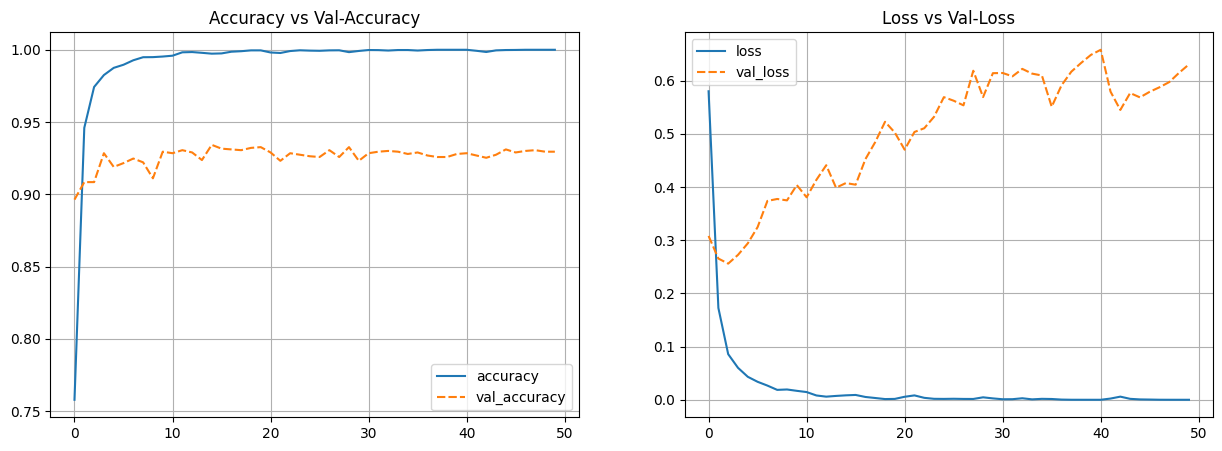

In [31]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

# 7. Model Saving

In [37]:
model_lstm_1.save('model.keras')

# 8. Model Inference

In [79]:
from keras.models import load_model

# Load the saved model
model = load_model('model.keras')

# Prepare the input data as a numpy array
input_data = np.array(['Tesla']) # replace with your input data

# Make predictions using the model
predictions = model.predict(input_data)

# Convert the predictions to labels
labels = np.argmax(predictions, axis=1)

# Print the labels
print(labels)

1/1 [==============================] - 1s 1s/step
[1]


In [81]:
from keras.models import load_model

# Define your category mapping
label_mapping = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

# Load the saved model
model = load_model('model.keras')

# Prepare the input data as a numpy array
input_data = np.array(['Tesla is fucking good as fuck go to hell you byd']) # replace with your input data

# Make predictions using the model
predictions = model.predict(input_data)

# Convert the predictions to labels
labels = np.argmax(predictions, axis=1)

# Map labels to categories
predicted_categories = [label_mapping[label] for label in labels]

# Print the predicted categories
print(predicted_categories)


1/1 [==============================] - 1s 1s/step
['negative']
